# Investigating the Multilinguality of BERT

In [2]:
!pip install transformers datasets spacy conllu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-

In [3]:
import conllu

def load_conllu(filename):
    for sentence in conllu.parse(open(filename, "rt", encoding="utf-8").read()):
        tokenized_words = [token["form"] for token in sentence]
        gold_tags = [token["upos"] for token in sentence]
        yield tokenized_words, gold_tags
        
corpus = list(load_conllu("/kaggle/input/sequoi-ud-fr/fr_sequoia-ud-test.conllu"))


## Converting the Conllu file into a DataFrame

In [4]:
import pandas as pd


def conllu2df(corpus:list) -> pd.DataFrame:
    
    df = pd.DataFrame(corpus, columns=["Words", "Tags"])
    df["SentenceID"] = df.index
    df = df.explode(["Words", "Tags"], ignore_index=True)     # Use explode to flatten each column
    df = df[["SentenceID", "Words", "Tags"]]
    df.columns = ["sentenceID", "token", "tag"]
    return df 

## Label's Distribution

<Axes: xlabel='tag'>

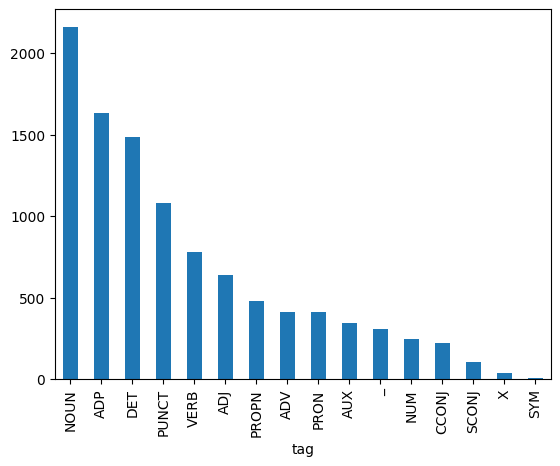

In [5]:
df = conllu2df(corpus)
df['tag'].value_counts().plot.bar()


In [6]:
# multiword tokens
df[df['tag'] == '_']['token'].unique()

array(['des', 'du', 'Aux', 'au', 'desdites', 'Au', 'aux', 'DES'],
      dtype=object)

In [7]:
# The multiword tokens are annotated by ' _ ' 
df[df['sentenceID'] == 2]

,sentenceID,token,tag
80,2,Je,PRON
81,2,me,PRON
82,2,pose,VERB
83,2,également,ADV
84,2,des,DET
85,2,questions,NOUN
86,2,quant,ADV
87,2,à,ADP
88,2,la,DET
89,2,sagesse,NOUN


In [8]:
# NUM tags contains Spaces They should be ommited
df[df['token'].str.contains(' ')]['tag'].value_counts()

# Removing the spaces from the tokens
df['token'] = df['token'].str.replace(' ', '', regex=False)

## mBert Tokenization

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [10]:
UD_tokens = df[df['sentenceID'] == 23]['tag'].to_list()
print(UD_tokens)

['VERB', 'PRON', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'PRON', 'PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', '_', 'ADP', 'DET', 'NOUN', 'PUNCT', 'PRON', 'AUX', 'AUX', 'VERB', '_', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'DET', 'NOUN', 'PUNCT', 'CCONJ', 'ADP', 'PRON', 'PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', '_', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADJ', 'PUNCT']


In [11]:
print("UD Tokenization:")
tokens = df[df['sentenceID'] == 23]['token'].to_list()
print(tokens)
print(len(tokens))
print()


print("mBert Tokenization:")
text= " ".join(df[df['sentenceID'] == 23]['token'].to_list())
print(tokenizer.tokenize(text))
print(len(tokenizer.tokenize(text)))


UD Tokenization:
['Pouvez', '-vous', 'donner', 'les', 'mêmes', 'garanties', 'en', 'ce', 'qui', 'concerne', 'la', 'taxe', 'proposée', 'sur', 'les', 'carburants', 'des', 'de', 'les', 'avions', ',', 'qui', 'a', 'été', 'débattue', 'au', 'à', 'le', 'sein', "d'", 'Écofin', 'cette', 'semaine', ',', 'et', 'en', 'ce', 'qui', 'concerne', "l'", 'impôt', 'sur', 'les', 'sociétés', 'au', 'à', 'le', 'sein', 'de', "l'", 'Union', 'européenne', '?']
53

mBert Tokenization:
['Po', '##uve', '##z', '-', 'vous', 'donner', 'les', 'mêmes', 'gara', '##nties', 'en', 'ce', 'qui', 'concerne', 'la', 'tax', '##e', 'proposé', '##e', 'sur', 'les', 'car', '##buran', '##ts', 'des', 'de', 'les', 'avions', ',', 'qui', 'a', 'été', 'débat', '##tue', 'au', 'à', 'le', 'sein', 'd', "'", 'É', '##co', '##fin', 'cette', 'semaine', ',', 'et', 'en', 'ce', 'qui', 'concerne', 'l', "'", 'im', '##pôt', 'sur', 'les', 'sociétés', 'au', 'à', 'le', 'sein', 'de', 'l', "'", 'Union', 'européenne', '?']
68


## Reconciling the Two Tokenizations

In [12]:
sentences = df[df['tag'] == '_']['sentenceID']

print("The sentences that contains multiwords")
print(sentences.unique())


multitokens_df = df[df['sentenceID'].isin(sentences.unique())]

The sentences that contains multiwords
[  1   2   3   4   5   8   9  11  14  15  17  19  22  23  25  26  27  28
  30  31  32  34  41  42  43  46  47  49  53  55  56  57  64  68  70  71
  73  76  78  86  87  88  89  90  98  99 101 102 103 105 107 108 110 115
 116 118 119 120 124 127 128 130 131 133 135 137 138 139 141 146 151 155
 157 160 163 165 166 185 189 191 195 197 199 204 205 212 215 221 229 232
 235 236 237 238 243 244 248 255 256 257 261 262 263 265 267 268 270 271
 274 290 291 296 297 298 303 304 305 308 309 311 314 322 323 325 330 332
 335 337 338 340 341 344 345 348 349 350 354 358 359 360 361 364 365 368
 369 379 380 381 382 383 384 385 387 388 393 397 398 399 402 404 405 406
 407 408 409 410 411 416 421 424 425 426 429 433 438 446 447 449 450]


In [13]:
tokens  = multitokens_df[multitokens_df['sentenceID'] == 397]['token'].to_list()
tags    = multitokens_df[multitokens_df['sentenceID'] == 397]['tag'].to_list()

In [14]:
print(tags)


list(zip(tokens,tags))

['DET', 'NOUN', 'PROPN', 'PRON', 'AUX', 'VERB', 'DET', 'NUM', 'NOUN', 'NUM', 'PUNCT', 'ADP', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'SCONJ', 'PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '_', 'ADP', 'DET', 'PROPN', 'PUNCT']


[('Le', 'DET'),
 ('Dr', 'NOUN'),
 ('Maréchal', 'PROPN'),
 ('lui', 'PRON'),
 ('aurait', 'AUX'),
 ('proposé', 'VERB'),
 ('le', 'DET'),
 ('11', 'NUM'),
 ('octobre', 'NOUN'),
 ('1994', 'NUM'),
 (',', 'PUNCT'),
 ('de', 'ADP'),
 ('faire', 'VERB'),
 ('pression', 'NOUN'),
 ('sur', 'ADP'),
 ('son', 'DET'),
 ('gendre', 'NOUN'),
 ('pour', 'ADP'),
 ("qu'", 'SCONJ'),
 ('il', 'PRON'),
 ('freine', 'VERB'),
 ('son', 'DET'),
 ('instruction', 'NOUN'),
 ('en', 'ADP'),
 ('direction', 'NOUN'),
 ('des', '_'),
 ('de', 'ADP'),
 ('les', 'DET'),
 ('Hauts-de-Seine', 'PROPN'),
 ('.', 'PUNCT')]

### UD “updated” tokenziation and UD “updated” labels 

In [15]:
def update_UD_tokenization(tokens: list[str], tags: list[str]):
    updated_tokens = []
    updated_tags = []
    i = 0
    while i < len(tags):
        if tags[i] == '_':
            # Merge next two tags
            merged_tag = tags[i + 1] + '+' + tags[i + 2]
            updated_tags.append(merged_tag)
            updated_tokens.append(tokens[i])
            i += 3  # Skip the next two elements
        else:
            updated_tags.append(tags[i])
            updated_tokens.append(tokens[i])
            i += 1

    assert len(updated_tags) == len(updated_tokens)
    return updated_tokens, updated_tags

In [16]:
# Testing the function

updated_tokens, updated_tags = update_UD_tokenization(tokens,tags)
updated_tags

['DET',
 'NOUN',
 'PROPN',
 'PRON',
 'AUX',
 'VERB',
 'DET',
 'NUM',
 'NOUN',
 'NUM',
 'PUNCT',
 'ADP',
 'VERB',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 'ADP',
 'SCONJ',
 'PRON',
 'VERB',
 'DET',
 'NOUN',
 'ADP',
 'NOUN',
 'ADP+DET',
 'PROPN',
 'PUNCT']

In [17]:
df

,sentenceID,token,tag
0,0,cela,PRON
1,0,signifie,VERB
2,0,que,SCONJ
3,0,leur,DET
4,0,consommation,NOUN
...,...,...,...
10349,454,les,DET
10350,454,fraudes,NOUN
10351,455,Quatrième,ADJ
10352,455,République,NOUN


In [18]:
import pandas as pd

def update_tags_tokens(corpus_df) -> dict:
    all_updated_tags   = []
    all_updated_tokens = []
    
    for i in range(len(corpus_df['sentenceID'].unique())):
        
        tokens  = corpus_df[corpus_df['sentenceID'] == i]['token'].to_list()
        tags    = corpus_df[corpus_df['sentenceID'] == i]['tag'].to_list()
    
        updated_tokens, updated_tags = update_UD_tokenization(tokens,tags)
        
        all_updated_tags.append(updated_tags)
        all_updated_tokens.append(updated_tokens)
        
    return all_updated_tags, all_updated_tokens



In [19]:
all_updated_tags, all_updated_tokens =  update_tags_tokens(df)

In [20]:
index_example = 10
print(f"List of tokens for the {index_example}-th example:\n{all_updated_tokens[index_example]}")
print(f"List of tags for the {index_example}-th example:\n{all_updated_tags[index_example]}")

List of tokens for the 10-th example:
['Revenons', '-en', 'à', "l'", 'actualité', '.']
List of tags for the 10-th example:
['VERB', 'PRON', 'ADP', 'DET', 'NOUN', 'PUNCT']


### Padding to match the mBert Tokenization

In [21]:
texts= ['What a wonderful world!']
print(tokenizer.tokenize("What a wonderful world!"))


['What', 'a', 'won', '##der', '##ful', 'world', '!']


In [22]:
for l in all_updated_tokens[0:3]:
    print(l)
    print()

['cela', 'signifie', 'que', 'leur', 'consommation', 'énergétique', ',', 'qui', 'représente', 'actuellement', '10', '%', 'de', 'la', 'consommation', 'énergétique', 'moyenne', 'de', "l'", 'UE', ',', 'enregistrera', 'une', 'forte', 'augmentation', 'à', 'mesure', "qu'", 'ils', 'exigeront', 'des', 'commodités', 'élémentaires', 'comme', "l'", 'eau', 'chaude', 'et', ',', 'peut-être', 'même', ',', "l'", 'air', 'conditionné', ',', 'des', 'moyens', 'de', 'transport', 'et', 'la', 'modernisation', 'de', 'leurs', 'industries', '.']

['Nous', 'avons', 'noté', 'que', 'la', 'production', "d'", 'électricité', 'correspond', 'à', '30', '%', 'des', 'émissions', 'de', 'CO2', 'imputables', 'à', "l'", 'homme', '.']

['Je', 'me', 'pose', 'également', 'des', 'questions', 'quant', 'à', 'la', 'sagesse', 'de', "l'", 'EU', 'et', 'sa', 'réaction', 'à', 'la', 'formation', 'du', 'gouvernement', 'en', 'Autriche', 'et', 'la', 'manière', 'dont', 'cela', 'affectera', "l'", 'opinion', 'publique', 'là-bas', '.']



In [23]:
example = 100
encoded_inputs = tokenizer(all_updated_tokens,
                          is_split_into_words=True,
                          return_offsets_mapping=True,
                          padding=True,
                          truncation=True,
                           add_special_tokens=False,
                         )

# input the sentences and labels
print("tokens")
print(all_updated_tokens[example])
print('tags')
print(all_updated_tags[example])

#print(tokenizer.tokenize("Nous ne pouvons nous demander ce qu'il adviendra du Kosovo."))


#print(t['input_ids'][1:-1])
print(encoded_inputs['input_ids'][example])



tokens
['En', 'plein', 'midi', ',', 'la', 'ville', 'de', 'Maxéville', 'sera', 'plongée', 'durant', 'quelques', 'secondes', 'dans', 'la', 'nuit', '.']
tags
['ADP', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'PROPN', 'AUX', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT']
[10243, 37695, 89663, 117, 10109, 11743, 10104, 12854, 109279, 11270, 16552, 20648, 13891, 11245, 13066, 15533, 57666, 10260, 10109, 26642, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
def align_tags(tags: list[str], offset_mapping: list[tuple[int, int]]) -> list[str]:
    """
    Aligns word-level tags with subword tokens using offset mapping.

    Parameters:
        tags (list[str]): A list of word-level tags (e.g., for NER or PoS).
        offset_mapping (list[tuple[int, int]]): The list of (start, end) character positions
                                                for each token produced by the tokenizer.

    Returns:
        list[str]: A list of aligned tags, where subword tokens are labeled as '<pad>'
    """
    tag_iter = iter(tags)
    aligned_tags = [next(tag_iter)]  # First tag is aligned with the first token
    prev_end = offset_mapping[0][1]

    for start, end in offset_mapping[1:]:
        if start == prev_end:
            aligned_tags.append('<pad>')  # Subword token
        else:
            aligned_tags.append(next(tag_iter, '<pad>'))  # Next word tag or pad
        prev_end = end

    assert len(aligned_tags) == len(offset_mapping)


    return aligned_tags


In [25]:
print("Aligning tags with subtokens.....")
def align_tags_with_subtokens(all_updated_tags,encoded_inputs):
    all_aligned_tags = []
    for index in range(len(all_updated_tags)):
        tags = all_updated_tags[index]
        offset_mapping = encoded_inputs['offset_mapping'][index]
        aligned_tags   = align_tags(tags,offset_mapping)
        all_aligned_tags.append(aligned_tags)
    return all_aligned_tags
    
all_aligned_tags = align_tags_with_subtokens(all_updated_tags,encoded_inputs)

Aligning tags with subtokens.....


In [26]:
from sklearn.preprocessing import LabelEncoder
from itertools import chain

 
le = LabelEncoder()
le.fit(list(chain.from_iterable(all_aligned_tags)))
 
le.transform(all_aligned_tags[101])


array([ 2, 15,  0,  7,  8,  2,  7,  8, 12,  7,  8, 15,  4,  3,  8, 11,  0,
        0,  0,  6,  2,  0,  3,  9,  8, 12,  7,  8, 15,  2,  7, 11, 15, 12,
        8,  3,  8, 12, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

## Create Dataset

In [27]:
from datasets import Dataset

def create_dataset(all_aligned_tags, encoded_inputs):
    """
    Create a Hugging Face Dataset from aligned tags and tokenized inputs.

    Parameters:
        all_aligned_tags (list[list[str]]): The aligned tags per example.
        encoded_inputs (dict): Tokenizer output with 'input_ids' and 'attention_mask'.

    Returns:
        datasets.Dataset: A Hugging Face dataset with input_ids, attention_mask, and labels.
    """
    data = [
        {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": le.transform(tags).tolist()
        }
        for input_ids, attention_mask, tags in zip(
            encoded_inputs["input_ids"],
            encoded_inputs["attention_mask"],
            all_aligned_tags
        )
    ]

    return Dataset.from_list(data)


In [28]:
train_df = conllu2df(list(load_conllu("/kaggle/input/sequoi-ud-fr/fr_sequoia-ud-dev.conllu")))
test_df  = conllu2df(list(load_conllu("/kaggle/input/sequoi-ud-fr/fr_sequoia-ud-test.conllu")))
dev_df   = conllu2df(list(load_conllu("/kaggle/input/sequoi-ud-fr/fr_sequoia-ud-dev.conllu")))

train_updated_tags, train_updated_tokens = update_tags_tokens(train_df)
test_update_tags, test_updated_tokens    = update_tags_tokens(test_df)
dev_update_tags, dev_updated_tokens      = update_tags_tokens(dev_df)


train_encoded_inputs = tokenizer(train_updated_tokens, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True, add_special_tokens=False,)
test_encoded_inputs  = tokenizer(test_updated_tokens,  is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True, add_special_tokens=False,)
dev_encoded_inputs   = tokenizer(dev_updated_tokens,   is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True, add_special_tokens=False,)

train_aligned_tags = align_tags_with_subtokens(train_updated_tags,train_encoded_inputs)
test_aligned_tags  = align_tags_with_subtokens(test_update_tags,test_encoded_inputs)
dev_aligned_tags   = align_tags_with_subtokens(dev_update_tags,dev_encoded_inputs)

le = LabelEncoder()
le.fit(list(chain.from_iterable(train_aligned_tags)))


train_ds = create_dataset(train_aligned_tags, train_encoded_inputs)
test_ds  = create_dataset(test_aligned_tags, test_encoded_inputs)
dev_ds  = create_dataset(dev_aligned_tags, dev_encoded_inputs)

In [29]:
print(train_ds)
print(test_ds)
print(dev_ds)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 412
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 456
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 412
})


## Fine-Tuning mBERT

In [30]:
import transformers
print(transformers.__version__)

4.51.3


In [31]:
batch_size = 16

from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model_checkpoint = "bert-base-multilingual-cased"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(le.classes_))
model.to('cuda')

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [36]:
batch_size = 16
training_args = TrainingArguments(
    output_dir="/kaggle/working/finetuned_models",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)